#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [39]:
# Testing if integration works

In [40]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [41]:
file_name = "/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/multicoil_train/file_brain_AXFLAIR_201_6002902.h5"
hf = h5py.File(file_name)

In [42]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004441969544241108, 'norm': 0.08727840658646836, 'patient_id': '0e13b8659e79753316c44ba284beee36b971a10142a5672e957e4a944d5f01ea'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [98]:
volume_kspace = hf['kspace'][()] # swap channels
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(14, 20, 640, 320)


In [99]:
##
#volume_kspace = np.swapaxes(volume_kspace, 0,1)
##
slice_kspace = volume_kspace[13] # Choosing the 20-th slice of this volume
#slice_kspace = volume_kspace[:,19,:,:] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [100]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap) 
        #plt.imshow(data[:,num,:,:], cmap=cmap)  #####CHEEEEEEEEEEEECK!!!!!!!!!!!!!!!!!!!
        

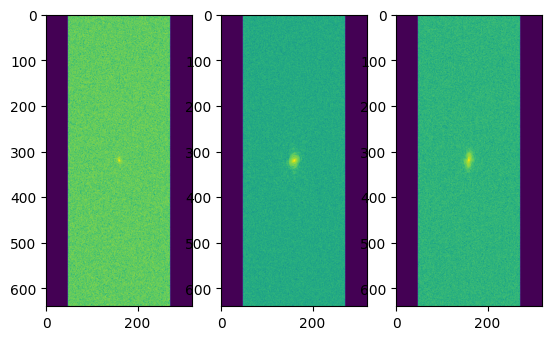

In [101]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [47]:
import fastmri
from tqdm.notebook import tqdm
from fastmri.data import transforms as T

In [102]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

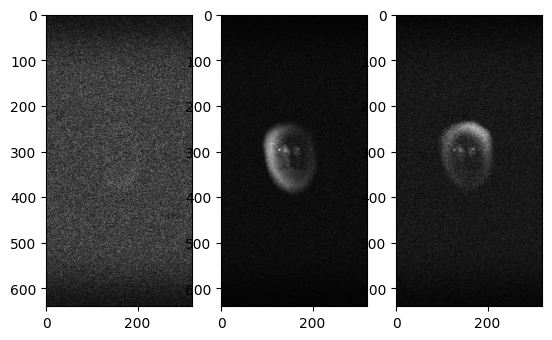

In [103]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [72]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

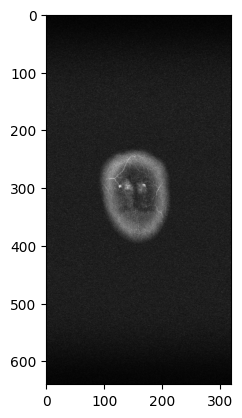

In [73]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [74]:
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFractionFunc, create_mask_for_mask_type
mask_func = EquispacedMaskFractionFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [75]:
masked_kspace, mask, rq = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
print(masked_kspace.shape, mask.shape, rq)

torch.Size([20, 640, 320, 2]) torch.Size([1, 1, 320, 1]) 13


In [76]:
mask_type="equispaced_fraction"  # VarNet uses equispaced mask
center_fractions = [0.08 ]
accelerations = [4] 
mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)


Let's see what the subsampled image looks like:

In [77]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

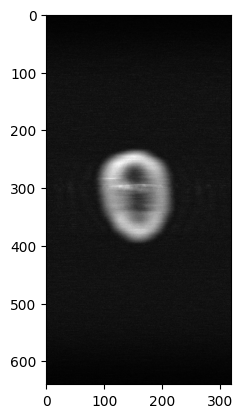

In [78]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

In [82]:
import torch
def extract_data(data, 
               mask_type="equispaced_fraction",  # VarNet uses equispaced mask
               center_fractions = [0.08 ],
               accelerations = [4] ):
    
    mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)
    volume_kspace = data['kspace'][()] # swap channels ?? Answer: No
    #volume_kspace = np.swapaxes(volume_kspace, 0,1) # uncomment if needed
    atbs = []
    atbs_before = []
    masks = []
    for slice_kspace in volume_kspace:
        slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
        
        #masked_kspace, mask, rq = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        #print(f"Num of low frequencies {rq}")

        masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        
        # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
        tiled_mask = mask[0,:,:,0]
        tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))


        sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image


        ## we need complex values -> real and imaginary parts are stored separately...
        sampled_image_complex = sampled_image[:,:,:,0]+1j*sampled_image[:,:,:,1]
        

        ## Apply Root-Sum-of-Squares (RSS) transform.
        sampled_image_rss = fastmri.rss(sampled_image_complex, dim = 0)
        sampled_image_rss_2 = fastmri.rss(np.abs(sampled_image_complex), dim = 0)  # Compute absolute value to get a real image

        ##* Note:  with sampled_image_rss_2 we obtain the same result as with : 
        #sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
        #sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
        

        #sampled_image_rss = np.abs(sampled_image_rss)
        atbs_before.append(sampled_image_rss_2.numpy())
        atbs.append(sampled_image_rss.numpy())
        masks.append(tiled_mask)#mask.numpy())
        
    # TODO: Comment the plot for routine.py
    slice = 13
    plt.subplot(1,2,1); plt.imshow(atbs_before[slice], cmap="gray"); plt.title('Absolute value before rss')
    plt.subplot(1,2,2); plt.imshow(np.abs(atbs[slice]), cmap="gray"); plt.title('Absolute value after rss')
    plt.tight_layout() 
    return np.asarray(atbs), np.asarray(masks)

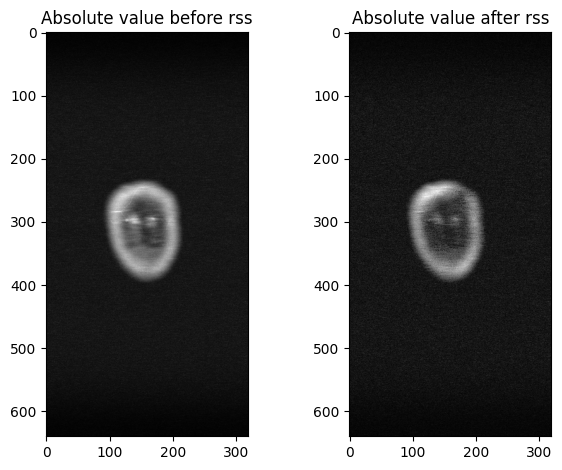

In [83]:
atb, mask = extract_data(hf)

In [84]:
print(mask.shape)
print(atb.shape)

(14, 640, 320)
(14, 640, 320)


<KeysViewHDF5 ['atb', 'csm', 'mask', 'org']>
<HDF5 dataset "atb": shape (1, 640, 368), type "<c8">
<HDF5 dataset "org": shape (1, 640, 368), type "<c8">
<HDF5 dataset "mask": shape (1, 640, 368), type "<c8">


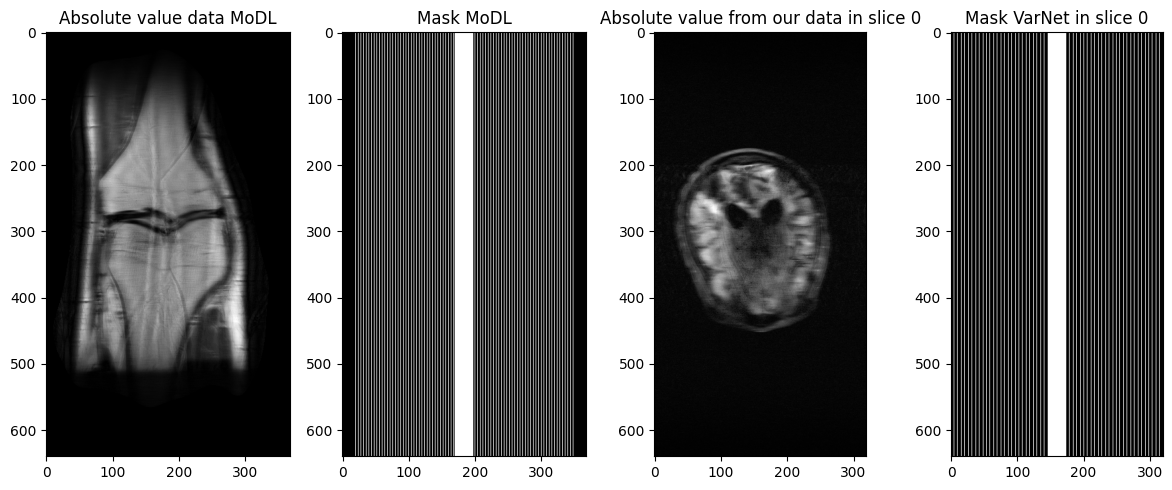

In [88]:
with h5py.File('/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/modl/knee_demo_data.h5','r') as f:
    print(f.keys())
    print(f['atb'])
    print(f['org'])
    print(f['mask'])
    
    #Plot
    plt.figure(figsize=(12,5))
    slice = 0
    plt.subplot(1,4,1); plt.imshow(np.abs(f['atb'][-1]), cmap="gray"); plt.title('Absolute value data MoDL')
    plt.subplot(1,4,3); plt.imshow(np.abs(atb[slice]), cmap="gray"); plt.title(f'Absolute value from our data in slice {slice}')
    plt.subplot(1,4,2); plt.imshow(np.abs(f['mask'][-1]), cmap="gray"); plt.title('Mask MoDL')
    plt.subplot(1,4,4); plt.imshow(mask[slice], cmap="gray"); plt.title(f'Mask VarNet in slice {slice}')
    plt.tight_layout() 